In [1]:
import os
import numpy as np 
import struct
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#数据预处理
def load_data(path,kind="train"): 
    labels_path=os.path.join(path,"%s-labels.idx1-ubyte"%kind) 
    images_path=os.path.join(path,"%s-images.idx3-ubyte"%kind) 
    with open(labels_path,'rb') as labpath:
        magic_number,item_number=struct.unpack(">II",labpath.read(8)) 
        labels=np.fromfile(labpath,dtype=np.uint8)
    with open(images_path,'rb') as imgpath: 
        magic_number,image_number,rows,cols=struct.unpack(">IIII",imgpath.read(16))
        print(magic_number)
        print(image_number)
        print(rows)
        images=np.fromfile(imgpath,dtype=np.uint8)
    return labels,images 
orig_labels,orig_images=np.array(load_data("./data",kind="train"))
#print("original labels shape is"+str(orig_labels.shape)) 
#print("original images shape is"+str(orig_images.shape))

def get_one_hot(targets,nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)] 

2051
60000
28


In [3]:
#将orig_image先reshape成（60000，784）
images=orig_images.reshape(60000,784)/255 
images=images.T 
#print(images.shape)
#因为输出层是softmax，因此需要将labels先进⾏one-hot编码
mid_labels=get_one_hot(orig_labels,10)
labels=mid_labels.T
print(images.shape)
print(labels.shape)

(784, 60000)
(10, 60000)


In [4]:
#加载数据集
orig_test_labels,orig_test_images=np.array(load_data("./data",kind="t10k"))
print(orig_test_labels.shape) 
print(orig_test_images.shape) 
test_images=orig_test_images.reshape(10000,784)/255 
test_images=test_images.T 
mid_test_labels=get_one_hot(orig_test_labels,10) 
test_labels=mid_test_labels.T
print(test_images.shape)
print(test_labels.shape)

2051
10000
28
(10000,)
(7840000,)
(784, 10000)
(10, 10000)


In [5]:
#NN&BP
np.random.seed(1)
#初始化隐藏层
def initializer_with_hidden_layers(num_hidden_units): 
    w1=np.random.randn(num_hidden_units,784) 
    b1=np.zeros((num_hidden_units,1)) 
    w2=np.random.randn(10,num_hidden_units) 
    b2=np.zeros((10,1))
    parameters={"w1":w1, "b1":b1,"w2":w2,"b2":b2}
    return parameters
def sigmoid(z): 
    s=1/(1+np.exp(-z)) 
    return s
def softmax(z): 
    total=np.sum(np.exp(z),axis=0,keepdims=True) 
    s=np.exp(z)/total
    return s

#定义前向传播函数，并且返回每⼀层当中激活函数的输出  
def forward_propagation(input_x,output_y,parameters): 
    #print("input shape:",input_x.shape)
    m=input_x.shape[1]
    w1=parameters["w1"] 
    #print("w1 shape:",w1.shape)
    b1=parameters["b1"] 
    w2=parameters["w2"] 
    b2=parameters["b2"] 
    a1=sigmoid(np.dot(w1,input_x)+b1) 
    a2=softmax(np.dot(w2,a1)+b2)
    #print("a2.shape:",a2.shape)
    #归一化后的交叉损失熵
    value_cost=0
    value_cost=-1/m*np.sum(output_y*np.log(a2))
    return a1,a2,value_cost

#定义后向传播过程
def backward_propagation(input_x,output_y,parameters,learning_rate,iterations): 
    m=input_x.shape[1]
    w1=parameters["w1"] 
    b1=parameters["b1"] 
    w2=parameters["w2"] 
    b2=parameters["b2"] 
    cost_list = []
    acc_list = []
    for i in range(iterations):
        a1,a2,cost=forward_propagation(input_x,output_y,parameters) 

        dz2=a2-output_y
        dw2=1/m*np.dot(dz2,a1.T) 
        db2=1/m*np.sum(dz2,axis=1,keepdims=True) 
        dz1=1/m*np.dot(w2.T,dz2)*a1*(1-a1)
        dw1=1/m*np.dot(dz1,input_x.T) 
        db1=1/m*np.sum(dz1,axis=1,keepdims=True) 
        w1=w1-learning_rate*dw1
        b1=b1-learning_rate*db1 
        w2=w2-learning_rate*dw2 
        b2=b2-learning_rate*db2 
        assert(w1.shape==dw1.shape) 
        assert(b1.shape==db1.shape) 
        assert(w2.shape==dw2.shape) 
        assert(b2.shape==db2.shape)
        y_predict=np.eye(10)[np.array(a2.argmax(0))].T##这是⽤与one-hot编码     
        acc=1-np.sum(np.abs(y_predict-output_y))/(2*m) 
        
        print("epoch["+str(i+1)+"/"+str(iterations)+"] "+"loss :"+str(cost)+" acc :"+str(acc)) 
        
        cost_list.append(cost)
        acc_list.append(acc)
        parameters={"w1":w1, "b1":b1,"w2":w2,"b2":b2}
        
        

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # 创建右侧y轴
    ax1.plot(range(1, iterations+1), cost_list, color='red', label='Cost')
    ax2.plot(range(1, iterations+1), acc_list, color='blue', label='Accuracy')
    ax1.set_ylabel('Cost')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Cost and Accuracy')
    ax2.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

    return parameters

In [6]:
def predict(input_x,output_y,parameters): 
    #m=output_y.shape[1]
    _,y_hat,_ =forward_propagation(input_x,output_y,parameters)
    y_predict=np.eye(10)[np.array(y_hat.argmax(0))]
    #print("shape:",y_predict.shape)
    return y_predict.T

def accuracy(y_predict,output_y): 
    assert(y_predict.shape==output_y.shape) 
    m=output_y.shape[1]
#     print(y_predict)
#     print(output_y)
#     print(np.sum(np.abs(y_predict-output_y)))
#     print(m)
    acc=1-np.sum(np.abs(y_predict-output_y))/(2*m) 
    return acc
def model(input_x,output_y,hidden_units,learning_rate,iterations):
    parameters=initializer_with_hidden_layers(hidden_units) 
    parameters=backward_propagation(input_x,output_y,parameters,learning_rate,iterations)
    y_prediction=predict(input_x,output_y,parameters) 
    acc=accuracy(y_prediction,output_y)
    print("the training-set accuracy is"+str(acc)) 
    return parameters


epoch[1/100] loss :34.189945871647076 acc :0.09194999999999998
epoch[2/100] loss :36.46988273929868 acc :0.08025000000000004
epoch[3/100] loss :37.37659284406054 acc :0.10781666666666667
epoch[4/100] loss :38.74681831105998 acc :0.11650000000000005
epoch[5/100] loss :38.00252092988065 acc :0.13690000000000002
epoch[6/100] loss :35.048278695365795 acc :0.17015000000000002
epoch[7/100] loss :37.58233251334239 acc :0.1996
epoch[8/100] loss :35.34869823841317 acc :0.14411666666666667
epoch[9/100] loss :27.970509773194834 acc :0.20716666666666672
epoch[10/100] loss :27.769794884283915 acc :0.29261666666666664
epoch[11/100] loss :22.804687451708038 acc :0.2877666666666666
epoch[12/100] loss :22.45383971938105 acc :0.2350833333333333
epoch[13/100] loss :24.130580066698197 acc :0.36095
epoch[14/100] loss :19.942850992140094 acc :0.3404166666666667
epoch[15/100] loss :17.723535936340003 acc :0.39288333333333336
epoch[16/100] loss :15.849587424661593 acc :0.3364666666666667
epoch[17/100] loss :1

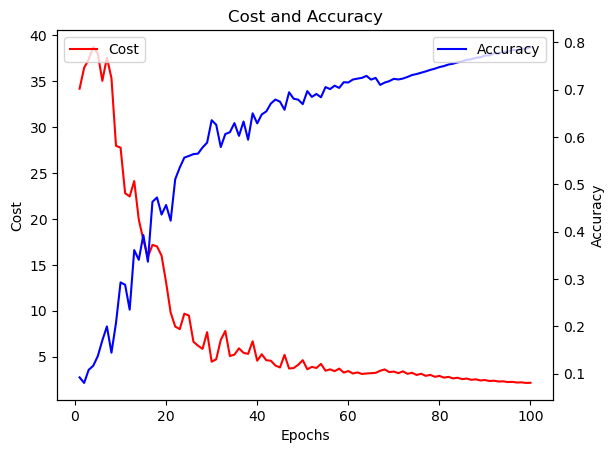

the training-set accuracy is0.7892
the testing-set accuracy is0.7957


In [7]:
parameters=model(images,labels,hidden_units=784,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))



epoch[1/100] loss :33.588101820890046 acc :0.11958333333333337
epoch[2/100] loss :41.19413663932972 acc :0.16505000000000003
epoch[3/100] loss :46.551428269757054 acc :0.13829999999999998
epoch[4/100] loss :46.66922057265286 acc :0.14800000000000002
epoch[5/100] loss :50.00855817189784 acc :0.18774999999999997
epoch[6/100] loss :53.43953751613183 acc :0.2933
epoch[7/100] loss :38.32259041741298 acc :0.19361666666666666
epoch[8/100] loss :35.20752853802209 acc :0.32248333333333334
epoch[9/100] loss :35.65980453078684 acc :0.2299
epoch[10/100] loss :40.40742408448279 acc :0.36811666666666665
epoch[11/100] loss :33.082536183060824 acc :0.28836666666666666
epoch[12/100] loss :29.82266850178146 acc :0.3475666666666667
epoch[13/100] loss :22.804207979033688 acc :0.3956333333333333
epoch[14/100] loss :22.729253358867556 acc :0.39154999999999995
epoch[15/100] loss :21.293186630386952 acc :0.3791833333333333
epoch[16/100] loss :18.38590604162642 acc :0.3468833333333333
epoch[17/100] loss :21.85

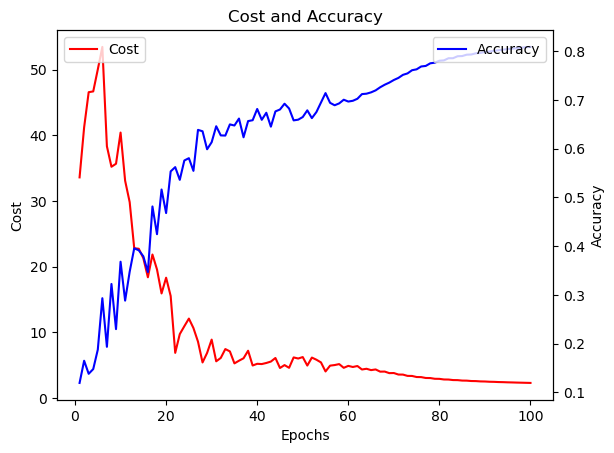

the training-set accuracy is0.80975
the testing-set accuracy is0.8174


In [10]:
parameters=model(images,labels,hidden_units=1024,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/100] loss :20.827945550912336 acc :0.09791666666666665
epoch[2/100] loss :21.501370882126885 acc :0.09961666666666669
epoch[3/100] loss :21.135907653451532 acc :0.13790000000000002
epoch[4/100] loss :15.22923734547352 acc :0.13526666666666665
epoch[5/100] loss :14.674866894977255 acc :0.17776666666666663
epoch[6/100] loss :14.275099657826242 acc :0.23250000000000004
epoch[7/100] loss :15.95361901134546 acc :0.16385000000000005
epoch[8/100] loss :14.877951956656553 acc :0.26636666666666664
epoch[9/100] loss :13.452701808904731 acc :0.21038333333333337
epoch[10/100] loss :12.1248662288591 acc :0.31715000000000004
epoch[11/100] loss :10.41285413884164 acc :0.37836666666666663
epoch[12/100] loss :10.006626554285239 acc :0.26846666666666663
epoch[13/100] loss :10.941391436804702 acc :0.40288333333333337
epoch[14/100] loss :9.12133016657009 acc :0.3718
epoch[15/100] loss :9.216123084969185 acc :0.3854833333333333
epoch[16/100] loss :8.73294004524066 acc :0.40703333333333336
epoch[17/

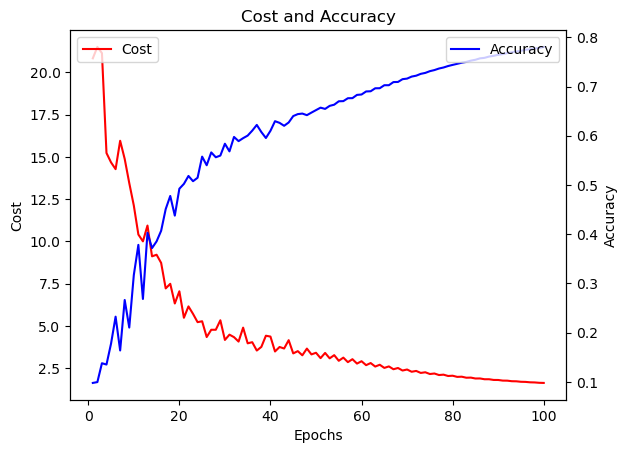

the training-set accuracy is0.7809166666666667
the testing-set accuracy is0.7895


In [14]:
parameters=model(images,labels,hidden_units=512,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/100] loss :15.731736011041873 acc :0.1159
epoch[2/100] loss :13.188767522071448 acc :0.12696666666666667
epoch[3/100] loss :10.82655657606282 acc :0.1086166666666667
epoch[4/100] loss :9.531086512028853 acc :0.15006666666666668
epoch[5/100] loss :8.676125603697 acc :0.1554833333333333
epoch[6/100] loss :7.901480221637387 acc :0.17779999999999996
epoch[7/100] loss :7.439034563553143 acc :0.22078333333333333
epoch[8/100] loss :7.12392490855837 acc :0.20376666666666665
epoch[9/100] loss :6.8536940039116105 acc :0.2644833333333333
epoch[10/100] loss :6.1643077632402825 acc :0.23301666666666665
epoch[11/100] loss :6.025899719493943 acc :0.31355
epoch[12/100] loss :5.692197771895781 acc :0.26421666666666666
epoch[13/100] loss :5.435599964801021 acc :0.3542333333333333
epoch[14/100] loss :4.973244944506342 acc :0.2936333333333333
epoch[15/100] loss :4.8707280210484685 acc :0.3963
epoch[16/100] loss :4.790482330252432 acc :0.31018333333333337
epoch[17/100] loss :4.58736455216864 acc :0

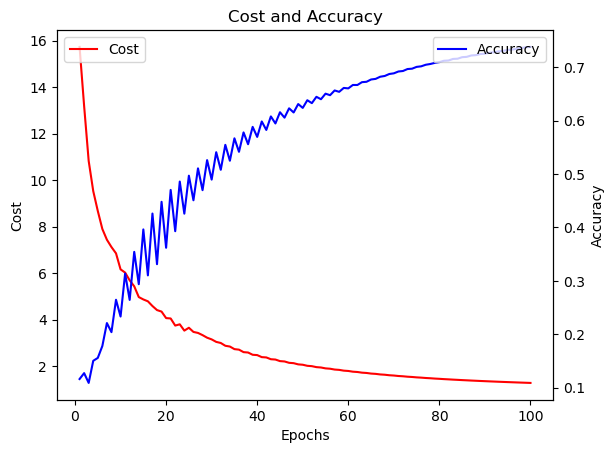

the training-set accuracy is0.74015
the testing-set accuracy is0.7508


In [17]:
parameters=model(images,labels,hidden_units=256,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/100] loss :8.949726224283774 acc :0.10235000000000005
epoch[2/100] loss :6.973451130428008 acc :0.16846666666666665
epoch[3/100] loss :6.341981835735687 acc :0.1285166666666666
epoch[4/100] loss :5.292447032338988 acc :0.18853333333333333
epoch[5/100] loss :4.965988201783393 acc :0.17831666666666668
epoch[6/100] loss :4.710632032972965 acc :0.2280833333333333
epoch[7/100] loss :4.498441149179672 acc :0.2083666666666667
epoch[8/100] loss :4.27428894203813 acc :0.2602333333333333
epoch[9/100] loss :4.059293785367928 acc :0.24919999999999998
epoch[10/100] loss :3.897746567588887 acc :0.2904833333333333
epoch[11/100] loss :3.684902324099077 acc :0.2949833333333334
epoch[12/100] loss :3.572826200618537 acc :0.3193666666666667
epoch[13/100] loss :3.3836711675295943 acc :0.33476666666666666
epoch[14/100] loss :3.2977335699403887 acc :0.34581666666666666
epoch[15/100] loss :3.1424503040914877 acc :0.3667166666666667
epoch[16/100] loss :3.069484157872485 acc :0.36993333333333334
epoch[1

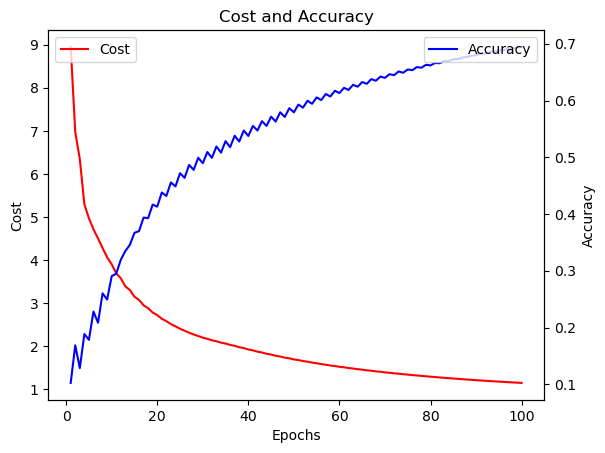

the training-set accuracy is0.6954833333333333
the testing-set accuracy is0.7070000000000001


In [15]:
parameters=model(images,labels,hidden_units=128,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/100] loss :49.911166826215116 acc :0.10941666666666672
epoch[2/100] loss :68.22871227142602 acc :0.13390000000000002
epoch[3/100] loss :81.64920443354535 acc :0.14490000000000003
epoch[4/100] loss :88.32009227365405 acc :0.24150000000000005
epoch[5/100] loss :111.6292416113926 acc :0.23833333333333329
epoch[6/100] loss :91.63670567771672 acc :0.2402833333333333
epoch[7/100] loss :98.82390790027783 acc :0.21928333333333339
epoch[8/100] loss :108.20933141935384 acc :0.3423833333333334
epoch[9/100] loss :87.90588053070303 acc :0.16336666666666666
epoch[10/100] loss :93.21239107620211 acc :0.3755666666666667
epoch[11/100] loss :81.69287961768447 acc :0.29536666666666667
epoch[12/100] loss :91.07952641162991 acc :0.4215
epoch[13/100] loss :82.48463625609858 acc :0.3035333333333333
epoch[14/100] loss :82.69132563633632 acc :0.401
epoch[15/100] loss :78.01177640658891 acc :0.23938333333333328
epoch[16/100] loss :65.17268162376698 acc :0.3732
epoch[17/100] loss :55.12091927561969 acc :

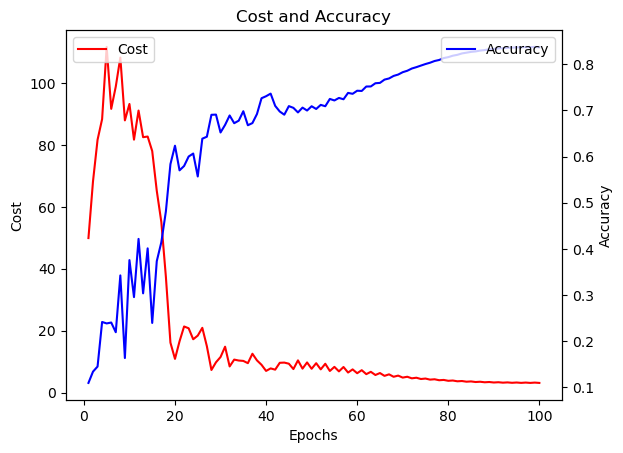

the training-set accuracy is0.8372833333333334
the testing-set accuracy is0.8441


In [16]:
parameters=model(images,labels,hidden_units=2048,learning_rate=1,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))

epoch[1/100] loss :33.588101820890046 acc :0.11958333333333337
epoch[2/100] loss :28.211097400526704 acc :0.16095000000000004
epoch[3/100] loss :26.8899978961479 acc :0.12278333333333336
epoch[4/100] loss :22.98804769855429 acc :0.20043333333333335
epoch[5/100] loss :21.73734588715818 acc :0.17459999999999998
epoch[6/100] loss :14.718378796803115 acc :0.23916666666666664
epoch[7/100] loss :12.818406362944058 acc :0.22924999999999995
epoch[8/100] loss :12.189187937905448 acc :0.26478333333333337
epoch[9/100] loss :11.42622687046067 acc :0.27141666666666664
epoch[10/100] loss :11.545282990054565 acc :0.3036833333333333
epoch[11/100] loss :11.3715174771924 acc :0.30266666666666664
epoch[12/100] loss :10.973416104049265 acc :0.3345166666666667
epoch[13/100] loss :10.033632206306953 acc :0.33901666666666663
epoch[14/100] loss :10.01631280012169 acc :0.36
epoch[15/100] loss :9.689579042191344 acc :0.3804166666666666
epoch[16/100] loss :9.016326426254546 acc :0.3881833333333333
epoch[17/100] 

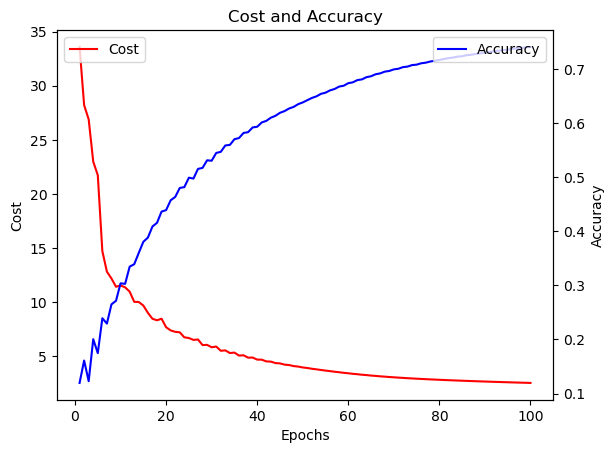

the training-set accuracy is0.7416333333333334
the testing-set accuracy is0.7524


In [9]:
parameters=model(images,labels,hidden_units=1024,learning_rate=0.5,iterations=100)
test_y_prediction=predict(test_images,test_labels,parameters) 
test_accuracy=accuracy(test_y_prediction,test_labels)
print("the testing-set accuracy is"+str(test_accuracy))